In [1]:
import os
import glob
import numpy as np
import pandas as pd
import astropy.io.fits as pf
from astropy.time import Time
import matplotlib.pyplot as plt
from skyfield.api import load, wgs84, EarthSatellite 
from skyfield.units import Angle

path = '/Users/Peter/Projects/starlink_data/'

In [2]:
vmags = np.sort(glob.glob(f"{path}vmags_subset/vmags_*.p"))
vc = pd.read_pickle(vmags[0])
ve = pd.read_pickle(vmags[1])
vn = pd.read_pickle(vmags[2])
vs = pd.read_pickle(vmags[3])
vw = pd.read_pickle(vmags[4])

In [3]:
def reduce_passages(camid):
    all_passages = pd.read_pickle(f"{path}vmags_subset/passages_subset/passages_20221023{camid}.p")
    pool = pd.read_pickle(f"{path}vmags_subset/selection_pool_subset/pool_{camid}.p")
    
    passages = {}
    for lstseq, data in all_passages.items():
        if lstseq in pool:
            passages[lstseq] = {}
            for satnum in pool[lstseq]:
                if satnum in data:
                    passages[lstseq][satnum] = data[satnum]
                    
    return passages

In [4]:
lsc = reduce_passages('LSC')
lsn = reduce_passages('LSN')
lss = reduce_passages('LSS')
lse = reduce_passages('LSE')
lsw = reduce_passages('LSW')

## Probably want to create a list of the vmag measurements for each satellite

In [5]:
def sat_list(vmags, camid):
    all_sats = []
    for lstseq in vmags:
        all_sats.extend(list(vmags[lstseq])[2:])
    
    # only keep unique elements
    sats = list(set(all_sats)) 
    print(f'{camid}: {len(all_sats)} observations;  {len(sats)} unique starlinks')
    return sats

In [6]:
sats_c = sat_list(vc, 'LSC')
sats_n = sat_list(vn, 'LSN')
sats_s = sat_list(vs, 'LSS')
sats_e = sat_list(ve, 'LSE')
sats_w = sat_list(vw, 'LSW')

LSC: 107 observations;  23 unique starlinks
LSN: 51 observations;  11 unique starlinks
LSS: 300 observations;  40 unique starlinks
LSE: 40 observations;  9 unique starlinks
LSW: 418 observations;  54 unique starlinks


In [7]:
all_sats = sats_c + sats_n + sats_s + sats_e + sats_w
all_sats = list(set(all_sats))
print(f'{len(all_sats)} unique Starlink observations')

86 unique Starlink observations


In [8]:
def vmags_per_sat(vmags, sats):
    
    # Creating a dictionary where each key is a unique satellite
    mydict = {}
    for sat in sats:
        mydict[sat] = {'vmags':[], 'JD':[], }
    
    # Now we will populate each key with the vmag measurements
    for lstseq in list(vmags):
        satnums = list(vmags[lstseq])[2:]
        for satnum in satnums:
            if satnum in mydict.keys():
                vmag = vmags[lstseq][satnum]['vmag']
                mydict[satnum]['vmags'].append(vmag)
                jd = vmags[lstseq]['JD0']
                mydict[satnum]['JD'].append(jd)
                
    df = pd.DataFrame([(sat, vmag, jd) for sat, values in mydict.items() for vmag, jd in zip(values['vmags'], 
                values['JD'])], columns=['satnum', 'vmag', 'JD'])
    
    return df

In [9]:
dfc = vmags_per_sat(vc, sats_c)
dfn = vmags_per_sat(vn, sats_n)
dfs = vmags_per_sat(vs, sats_s)
dfe = vmags_per_sat(ve, sats_e)
dfw = vmags_per_sat(vw, sats_w)

## Should now use this info to get inclinations etc and plot as a function of these!
### Doing simple stats for now

In [10]:
def vmag_averages(df, sats):
    
    mydict = {}
    for sat in sats:
        vmags = []
        mydict[sat] = {}
        vmags.extend(df.loc[df.satnum==sat, 'vmag'].values)
        mydict[sat] = np.mean(vmags)
        
    return mydict

In [11]:
avg_c = vmag_averages(dfc, sats_c)
avg_n = vmag_averages(dfn, sats_n)
avg_s = vmag_averages(dfs, sats_s)
avg_w = vmag_averages(dfw, sats_w)
avg_e = vmag_averages(dfe, sats_e)

23
11
40
9
54


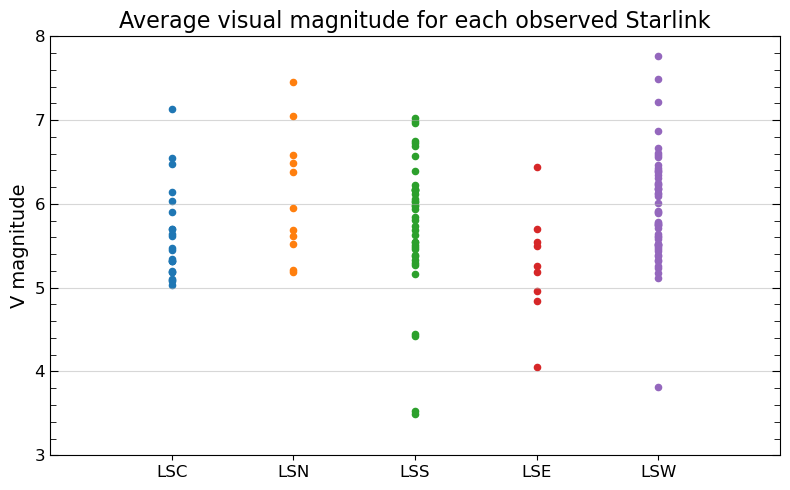

In [12]:
fig, ax = plt.subplots(1, 1, figsize=[8,5])

for i, avg in enumerate([avg_c, avg_n, avg_s, avg_e, avg_w]):
    vmags = []
    for sat in avg.keys():
        vmags.append(avg[sat])
    
    print(len(vmags))
    ax.scatter(np.ones(len(vmags))+i, vmags, s=20)
    
labels = ('LSC', 'LSN', 'LSS', 'LSE', 'LSW')
ax.set_xticks([1,2,3,4,5], labels)
ax.set_ylim([3, 8])
ax.set_xlim([0, 6])
ax.set_title('Average visual magnitude for each observed Starlink', fontsize=16)
ax.set_ylabel('V magnitude', fontsize=14)


ax.tick_params(axis='y', which='both', right=True, direction='in')
ax.tick_params(axis='y', which='major', length=6)
ax.tick_params(axis='y', which='minor', length=4)
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.xaxis.set_tick_params(which='minor', bottom=False)
ax.yaxis.grid(alpha=0.5)

ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
# plt.savefig('avg_vmags.png', dpi=300, bbox_inches='tight', facecolor='w')
plt.show()

# Number of images affected
### subset: 467 images for each camera
#### First / last LSTSEQ = 48506263, 48506747

In [13]:
for vmags in [vc,vn,vs,ve,vw]:
    print(len(vmags.keys()))

237
291
437
168
450


In [14]:
beg = 48506263
end = 48506747
end-beg

484

#### Each LSTSEQ is ~6.4 seconds of exposure time

In [15]:
all_images = np.arange(beg, end+1, 1)
indices = []
for lstseq in list(vc):
    num = int(lstseq)
    index = np.where(all_images == num)[0][0]
    indices.append(index)


In [16]:
tot = int(484 * 6.4)
w = 60
int(tot/60)

51

In [17]:
def affected_images_lstseq():
    
    fig, axs = plt.subplots(2, 3, figsize=[12,6], sharex=True)
    
    x = 484
    bin_width = 10 # spacing by 64 seconds
    N = int(np.ceil(x / bin_width)) # Number of bins 
    
    beg = 48506263
    end = 48506747
    all_images = np.arange(beg, end+1, 1)
    combined_counts = [0] * N
    
    for ax, vmags, label in zip(axs.ravel()[1:],[vc,vn,vs,ve,vw],['C','N','S','E','W']):

        bin_counts = [0] * N  # Initialize count for each bin
    
        indices = []
        for lstseq in list(vmags):
            num = int(lstseq)
            index = np.where(all_images == num)[0][0]
            indices.append(index)

        for idx in indices:
            bin_number = idx + 1            
            bin_idx = int(bin_number / bin_width)  # Determine the bin index
            
            bin_counts[bin_idx] += 1 # Increment the count for the corresponding bin
            combined_counts[bin_idx] += 1
            
        # Generate the interval boundaries  
        bin_edges = [i * bin_width for i in range(N)] 
        
        ax.bar(bin_edges, bin_counts, width=bin_width, align='edge')
        ax.tick_params(which='both', direction='in', top=True, right=True)
        ax.text(0.1, 0.1, f'LS{label}', color='w', fontsize=14, transform=ax.transAxes)
        
    ax_combined = axs[0, 0]
    ax_combined.bar(bin_edges, combined_counts, width=bin_width, align='edge')
    ax_combined.tick_params(which='both', direction='in', top=True, right=True)
    ax_combined.set_ylabel('# images affected', fontsize=12)
    ax_combined.text(0.65, 0.87, 'Combined', fontsize=14, transform=ax_combined.transAxes)
    
    axs[1,0].set_ylabel('# images affected', fontsize=12)
    for ax in axs.ravel()[3:]:
        ax.set_xlabel('LSTSEQ', fontsize=12)
    
    plt.tight_layout()
    plt.show()

In [18]:
def affected_images_lstseq():
    
    fig, axs = plt.subplots(2, 3, figsize=[12,6], sharex=True)
    
    x = 484
    bin_width = 10 # spacing by 64 seconds
    N = int(np.ceil(x / bin_width)) # Number of bins 
    
    beg = 48506263
    end = 48506747
    all_images = np.arange(beg, end+1, 1)
    combined_counts = [0] * N
    
    for ax, vmags, label in zip(axs.ravel()[1:],[vc,vn,vs,ve,vw],['C','N','S','E','W']):

        bin_counts = [0] * N  # Initialize count for each bin
    
        indices = []
        for lstseq in list(vmags):
            num = int(lstseq)
            index = np.where(all_images == num)[0][0]
            indices.append(index)

        for idx in indices:
            bin_number = idx + 1            
            bin_idx = int(bin_number / bin_width)  # Determine the bin index
            
            bin_counts[bin_idx] += 1 # Increment the count for the corresponding bin
            combined_counts[bin_idx] += 1
            
        # Generate the interval boundaries  
        bin_edges = [i * bin_width - bin_width for i in range(N)] 
        
        ax.bar(bin_edges, bin_counts, width=bin_width, align='edge')
        ax.tick_params(which='both', direction='in', top=True, right=True)
        ax.text(0.1, 0.1, f'LS{label}', color='w', fontsize=14, transform=ax.transAxes)
        
    ax_combined = axs[0, 0]
    ax_combined.bar(bin_edges, combined_counts, width=bin_width, align='edge')
    ax_combined.tick_params(which='both', direction='in', top=True, right=True)
    ax_combined.set_ylabel('# images affected', fontsize=12)
    ax_combined.text(0.65, 0.87, 'Combined', fontsize=14, transform=ax_combined.transAxes)
    
    axs[1,0].set_ylabel('# images affected', fontsize=12)
    for ax in axs.ravel()[3:]:
        ax.set_xlabel('Image', fontsize=12)
    
    plt.tight_layout()
    plt.show()

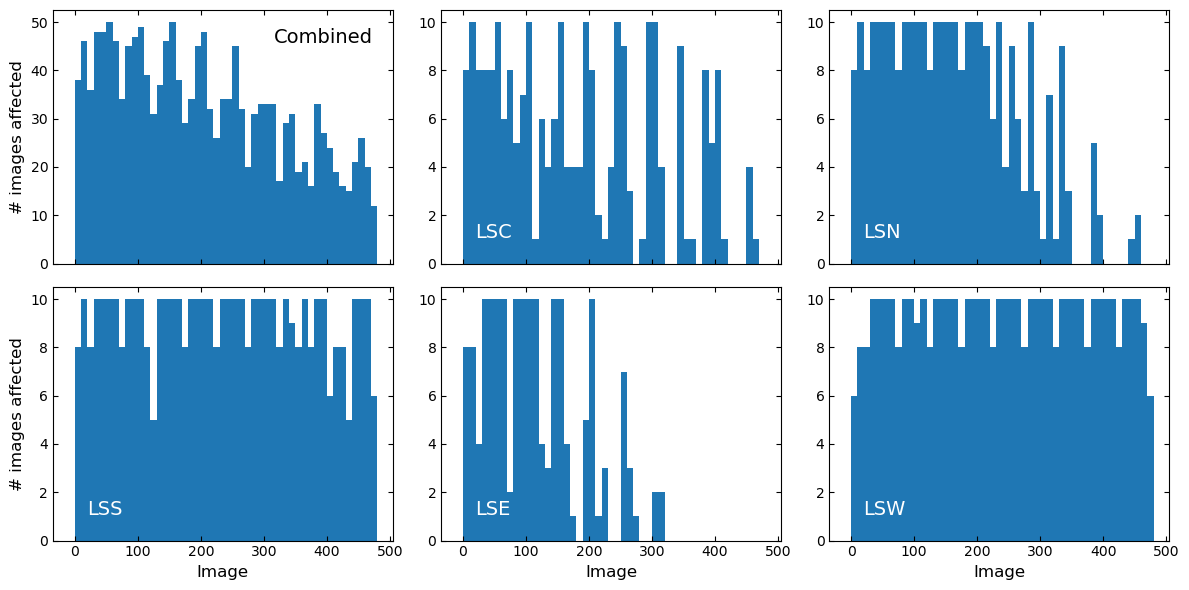

In [19]:
affected_images_lstseq()

In [20]:
def affected_images():
    
    fig, axs = plt.subplots(2, 3, figsize=[12,6], sharex=True)
    props = dict(boxstyle='round', facecolor='w')
    
    x = 484 * 6.4
    bin_width = 60 # spacing by 64 seconds
    N = int(np.ceil(x / bin_width)) # Number of bins 
    
    beg = 48506263
    end = 48506747
    all_images = np.arange(beg, end+1, 1)
    combined_counts = [0] * N
    all_indices = 0
    
    for ax, vmags, label in zip(axs.ravel()[1:],[vc,vn,vs,ve,vw],['C','N','S','E','W']):

        bin_counts = [0] * N  # Initialize count for each bin
    
        indices = []
        for lstseq in list(vmags):
            num = int(lstseq)
            index = np.where(all_images == num)[0][0]
            indices.append(index)

        for idx in indices:
            bin_number = (idx + 1)*6.4            
            bin_idx = int(bin_number / bin_width)  # Determine the bin index
            
            bin_counts[bin_idx] += 1 # Increment the count for the corresponding bin
            combined_counts[bin_idx] += 1
            
        # Generate the interval boundaries  
        bin_edges = [i * bin_width / 60 - bin_width / 120 for i in range(N)] 
        
        # (- bin_width / 120) shifts the bars to start from an x-axis value of 0 while being aligned 
        # with the left edge of each bin. By subtracting bin_width/2 from each bin_edges value, you 
        # shift the bars to start from an x-axis value of 0. 60 is for conversion to minutes
        
        # Fraction of images affected
        frac = round(len(indices)/467, 2)
        all_indices += len(indices)
        
        ax.bar(bin_edges, bin_counts, width=bin_width / 60, align='edge', color='C2', alpha=0.5)
        ax.tick_params(which='both', direction='in', top=True, right=True)
        ax.text(0.1, 0.075, f'LS{label}', fontsize=16, transform=ax.transAxes)
        ax.text(0.8, 0.85, frac, transform=ax.transAxes, fontsize=14, va='center', bbox=props)
        
        
    ax_combined = axs[0, 0]
    ax_combined.bar(bin_edges, combined_counts, width=bin_width / 60, align='edge', color='C2', alpha=0.5)
    ax_combined.tick_params(which='both', direction='in', top=True, right=True)
    ax_combined.set_ylabel('# images affected', fontsize=12)
    ax_combined.text(0.1, 0.075, 'Combined', fontsize=16, transform=ax_combined.transAxes)
    
    total_frac = round(all_indices/(467*5), 2)
    ax_combined.text(0.8, 0.85, total_frac, transform=ax_combined.transAxes, fontsize=14, va='center', bbox=props)
    
    axs[1,0].set_ylabel('# images affected', fontsize=12)
    for ax in axs.ravel()[3:]:
        ax.set_xlabel('Time [minutes]', fontsize=12)
    
    fig.suptitle('Bin width = 64 seconds', fontsize=16)
    plt.tight_layout()
    #plt.savefig('affected_images.png', facecolor='w', bbox_inches='tight', dpi=300)
    plt.show()

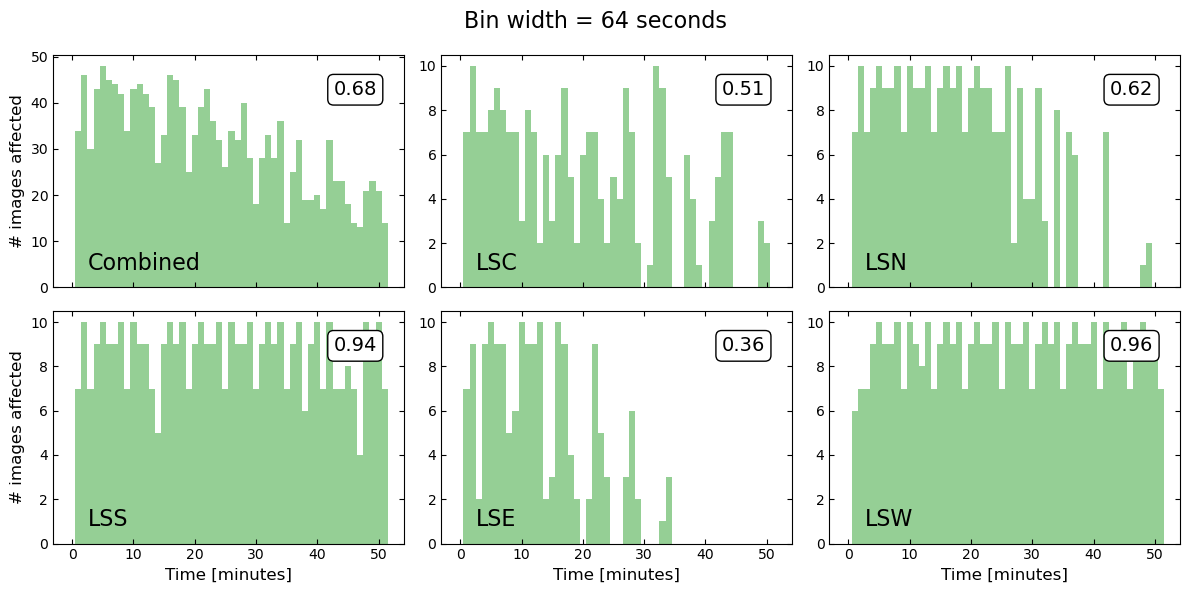

In [21]:
affected_images()

# Distinguishing type by launch

DarkSat: Starlink-1130 44932U

All satellites launched since the ninth launch at August 2020 have visors.

Visors that blocked sunlight were removed from satellites launched from September 2021 onwards.

30 June 2021 onwards -> V1.5

2023: 27 February, 19 April, 19 May  -> V2-mini

https://en.wikipedia.org/wiki/List_of_Starlink_and_Starshield_launches

In [22]:
def get_tles():
    
    # Load TLEs for all satellite passages
    satfiles = f"{path}/test_data/3leComplete.txt"
    with open(satfiles) as f:
        all_tles = f.readlines()
        f.close()

    # Split TLE list into individual lists for each TLE
    all_tles = [i.strip() for i in all_tles]
    tles = [all_tles[x:x+3] for x in range(0, len(all_tles), 3)]

    # Reduce TLEs to Starlink only
    starlink_tles = []
    for tle in tles:
        if "STARLINK" in tle[0]:
            starlink_tles.append(tle)
            
    for tle in starlink_tles:
        tle[0] = tle[0][2:]
        
    return starlink_tles

In [23]:
def get_starlink_launches():
    """
    For the scraping: probably not the best way, but essentially just adds everything to a list.
    Thinking have it this way such that it just needs to be run once.
    
    """
    
    import requests
    from bs4 import BeautifulSoup
    
    base_url = 'https://nssdc.gsfc.nasa.gov/nmc/spacecraft/query'
    search_params = {'name': 'starlink'}

    # Send a GET request to the website
    response = requests.get(base_url, params=search_params)

    # Parse the HTML content of the page
    soup = BeautifulSoup(response.text, 'html.parser')

    
    # Index 0: Name         ...  Starlink 1007
    # Index 1: NSSDCA ID    ...  2019-074A
    # Index 2: Launch date  ...  2019-11-11 (Y:M:D)
    
    i=0
    names = []
    dates = []

    # Find the table rows that contain satellite data
    for row in soup.find_all('td'):
        entry = row.get_text()
        i+=1
        if i==1:
            entry = entry.upper().replace(' ', '-') #since my data is uppercase and hyphenated
            names.append(entry)
        if i==2:
            continue
        if i==3:
            dates.append(entry)
            i=0
            
    df = pd.DataFrame({'name': names, 'launch': dates})
    df['launch'] = pd.to_datetime(df['launch'])
    

    starlink_tles = get_tles()
        
        
    # DarkSat = Starlink-1130 = 44932U
    # Visors - 7 August 2020
    # Visors removed - 14 September 2021 onwards
    # V1.5 - 30 June 2021 onwards
    # V2-mini: 27 February 2023, 19 April 2023, 19 May 2023 ---> out of our date range
    
    
    df2 = pd.DataFrame(columns=['starlink', 'satnum', 'launch', 'version', 'type'])
    for i, tle in enumerate(starlink_tles):
        starlink = tle[0]
        try:
            idx = np.where(df.name.values == starlink)[0][0]
        except:
            continue
        satnum = tle[1].split()[1]
        date = df.launch.iloc[idx]
        satname = df.name.iloc[idx]

        # v0.1
        if date < pd.to_datetime('2018-02-23'):
            version = '0.1'
            sattype = 'tintin'

        # v0.9
        if date > pd.to_datetime('2018-02-23') and date < pd.to_datetime('2019-11-12'):
            version = '0.9'
            sattype = 'standard'

        # v1.0
        if date > pd.to_datetime('2019-11-12') and date < pd.to_datetime('2021-05-27'):
            version = '1.0'
            if satnum == '44932U':
                sattype = 'darksat'
            elif date > pd.to_datetime('2020-06-30'):
                sattype = 'visorsat'
            else:
                sattype = 'standard'

        # v1.5
        if date > pd.to_datetime('2021-05-27'):
            version = '1.5'
            if date < pd.to_datetime('2021-09-13'):
                sattype = 'visorsat'
            else:
                sattype = 'standard'


        row_data = [satname, satnum, date, version, sattype]
        df2.loc[len(df2)] = row_data
    
    return df2

In [24]:
df = get_starlink_launches()

In [25]:
print(df.type.value_counts())
print(df.version.value_counts())

standard    2084
visorsat    1088
darksat        1
Name: type, dtype: int64
1.5    1656
1.0    1463
0.9      54
Name: version, dtype: int64


In [26]:
def all_vmag_averages():
    
    df = pd.concat([dfc, dfn, dfs, dfe, dfw], ignore_index=True)
    mydict = {}
    for sat in all_sats:
        vmags = []
        mydict[sat] = {}
        vmags.extend(df.loc[df.satnum==sat, 'vmag'].values)
        mydict[sat] = np.mean(vmags)
        
    df2 = pd.DataFrame.from_dict(mydict, orient='index')
    df2 = df2.reset_index()
    df2.columns = ['satnum', 'vmag']

    return df2

In [27]:
def hist_sattypes():
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=[10,4])
    
    all_vmags = pd.concat([dfc, dfn, dfs, dfe, dfw], ignore_index=True)
    
    standard = []
    visors = []
    for i, satnum in enumerate(all_vmags.satnum.values):
        idx = np.where(satnum == df.satnum.values)[0][0]
        sattype = df.type.iloc[idx]
        if sattype=='standard':
            standard.append(all_vmags.vmag.iloc[i])
        elif sattype=='visorsat':
            visors.append(all_vmags.vmag.iloc[i])
            
    n_bins = 50          
    ax1.hist(standard, n_bins, color='C1', ec='grey', alpha=0.7)
    ax2.hist(visors, n_bins, color='C1', ec='grey', alpha=0.7)
    
    ax1.set_title('Standard Starlinks')
    ax2.set_title('Visored Starlinks')
    
    for ax in [ax1, ax2]:
        #ax.tick_params(axis='y', which='both', right=True, direction='in')
        ax.tick_params(which='both', direction='in', top=True, right=True)
        ax.tick_params(axis='both', which='major', length=6)
        ax.tick_params(axis='x', which='minor', length=4)
        ax.yaxis.get_ticklocs(minor=True)
        ax.minorticks_on()
        #ax.xaxis.set_ticxk_params(which='minor', bottom=False)
        ax.set_xlabel('V magnitude')
        
    plt.tight_layout()
    plt.show()

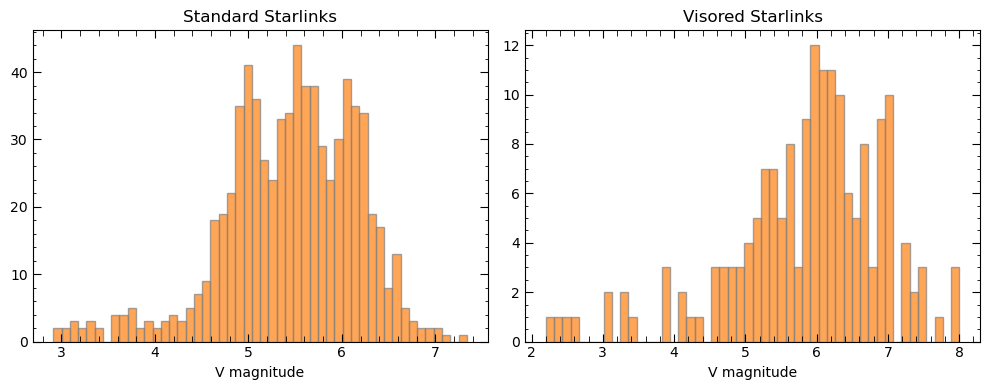

In [28]:
hist_sattypes()

In [29]:
def number_counts():
    
    all_vmags = pd.concat([dfc, dfn, dfs, dfe, dfw], ignore_index=True)
    
    visors = []
    darksat = []
    standard = []
    for i, satnum in enumerate(all_vmags.satnum.values):
        
        idx = np.where(satnum == df.satnum.values)[0][0]
        sattype = df.type.iloc[idx]
        
        if sattype=='standard':
            standard.append(satnum)
            
        if sattype=='visorsat':
            visors.append(satnum)
            
        if sattype=='darksat':
            darksat.append(satnum)
    
    print(f'{len(all_vmags)} total, {len(all_vmags.satnum.unique())} unique')
    print(f'Standard: {len(standard)} total, {len(np.unique(standard))} unique')
    print(f'VisorSat: {len(visors)} total, {len(np.unique(visors))} unique')
    print(f'DarkSat: {len(darksat)} total, {len(np.unique(darksat))} unique')

In [30]:
def hist_sattypes_all():
    fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=[12,6], sharex=True)
    
    all_vmags = pd.concat([dfc, dfn, dfs, dfe, dfw], ignore_index=True)
    
    visors = []
    darksat = []
    standard = []
    for i, satnum in enumerate(all_vmags.satnum.values):
        idx = np.where(satnum == df.satnum.values)[0][0]
        sattype = df.type.iloc[idx]
        if sattype=='standard':
            standard.append(all_vmags.vmag.iloc[i])
        if sattype=='visorsat':
            visors.append(all_vmags.vmag.iloc[i])
        if sattype=='darksat':
            darksat.append(all_vmags.vmag.iloc[i])
            
    number_counts()
            
    n_bins = 10   
    ax1.hist(all_vmags.vmag.values, color='C1', ec='grey', alpha=0.7)
    ax2.hist(standard, color='C1', ec='grey', alpha=0.7)
    ax3.hist(visors, color='C1', ec='grey', alpha=0.7)
    ax4.hist(darksat, color='C1', ec='grey', alpha=0.7)
    
    ax1.text(0.2, 0.7, 'All Starlinks', fontsize=16, transform=ax1.transAxes, ha='center', va='center')
    ax2.text(0.2, 0.7, 'Standard\nStarlinks', fontsize=16, transform=ax2.transAxes, ha='center', va='center')
    ax3.text(0.2, 0.7, 'Visored\nStarlinks', fontsize=16, transform=ax3.transAxes, ha='center', va='center')
    ax4.text(0.2, 0.7, 'DarkSat', fontsize=16, transform=ax4.transAxes, ha='center', va='center')
    
    for ax in [ax1, ax2, ax3, ax4]:
        ax.tick_params(which='both', direction='in', top=True, right=True)
        ax.tick_params(axis='both', which='major', length=6)
        ax.tick_params(axis='x', which='minor', length=4)
        ax.yaxis.get_ticklocs(minor=True)
        ax.minorticks_on()
        
    ax3.set_xlabel('V magnitude')
    ax4.set_xlabel('V magnitude')    
    plt.tight_layout()
    #plt.savefig('vmag_hist.png', facecolor='w', bbox_inches='tight', dpi=300)
    plt.show()

916 total, 86 unique
Standard: 738 total, 56 unique
VisorSat: 174 total, 29 unique
DarkSat: 4 total, 1 unique


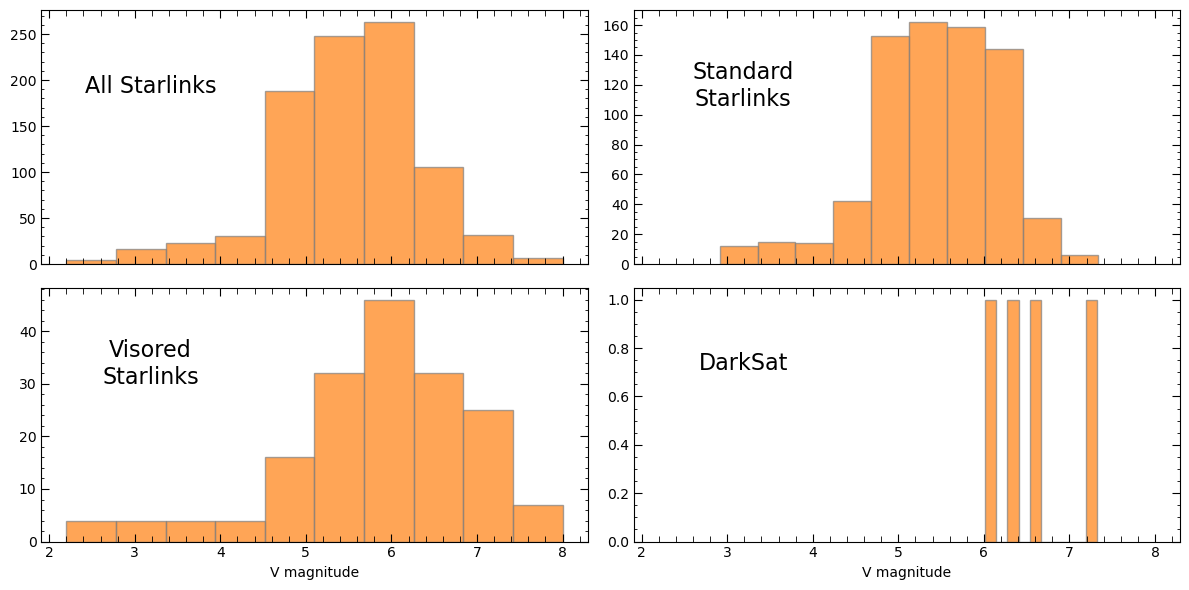

In [31]:
hist_sattypes_all()

# Orbital parameters

In [32]:
eph = load('de421.bsp')

def get_siteinfo():
    confdir = '/Users/Peter/Projects/starlink_data/fotos-python3/bringfiles/siteinfo.dat'
    dtype = [('sitename', '|U20'), ('lat', 'float32'), ('lon', 'float32'), ('height', 'float32'), ('ID', '|U2')]
    siteinfo = np.genfromtxt(confdir, dtype=dtype)   
    mask = siteinfo['ID'] == 'LS'
    siteinfo = siteinfo[mask]
    return siteinfo

In [33]:
def get_orbital_params(vmags):
    
    ts = load.timescale()
    site = get_siteinfo()
    mascara = wgs84.latlon(latitude_degrees=site[0][1], longitude_degrees=site[0][2], elevation_m=site[0][3])
    observer = mascara + eph['earth']
    
    starlink_tles = get_tles()
    
    df = pd.DataFrame(columns=['satnum', 'vmag', 'inc', 'height', 'alt', 'az', 'ra', 'dec', 'range'])

    for index, row in vmags.iterrows():
        satnum = row.satnum
        vmag = row.vmag
        JD = row.JD
        t = Time(JD, format='jd')
        
        for i, tle in enumerate(starlink_tles):
            if satnum in tle[1]:
                sat = EarthSatellite(tle[1], tle[2], tle[0], ts)
                inc = sat.model.inclo
                inc = Angle(radians=inc).degrees
                
                diff = sat - mascara
                topocentric = diff.at(ts.from_astropy(t))
                alt, az, dist = topocentric.altaz()
                ra, dec, _ = topocentric.radec() 
                
                geocentric = sat.at(ts.from_astropy(t))
                height = wgs84.height_of(geocentric)
                
                row_data = [satnum, vmag, inc, height.km, alt.degrees, az.degrees, ra.hours, dec.degrees, dist.km]
                df.loc[len(df)] = row_data
                break            
        
    return df

In [34]:
all_vmags = pd.concat([dfc, dfn, dfs, dfe, dfw], ignore_index=True)
orb_params = get_orbital_params(all_vmags)

In [35]:
orb_params.head()

,satnum,vmag,inc,height,alt,az,ra,dec,range
0,51797U,5.053048,53.2149,550.291226,74.390723,147.252893,22.582943,-42.040568,567.153842
1,51797U,5.179164,53.2149,550.407237,69.969088,145.332064,22.895927,-44.944904,580.281872
2,51797U,5.318387,53.2149,550.523219,65.743316,144.130841,23.223922,-47.516840,596.469132
3,47772U,5.962355,53.0564,556.712690,76.206353,198.111554,21.575762,-42.348081,569.431549
4,47772U,6.076220,53.0564,556.353565,84.279020,116.058351,22.369084,-31.748142,556.534229


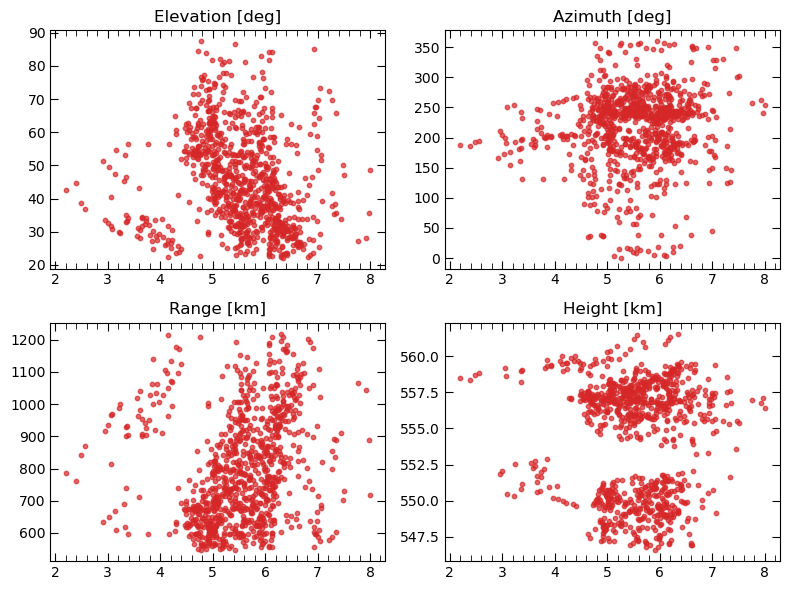

In [36]:
fig, axs = plt.subplots(2, 2, figsize=[8,6])

ax = axs[0,0]
ax.scatter(orb_params.vmag, orb_params.alt, s=10, c='C3', alpha=0.7)
ax.set_title('Elevation [deg]')

ax = axs[0,1]
ax.scatter(orb_params.vmag, orb_params.az, s=10, c='C3', alpha=0.7)
ax.set_title('Azimuth [deg]')

ax = axs[1,0]
ax.scatter(orb_params.vmag, orb_params.range, s=10, c='C3', alpha=0.7)
ax.set_title('Range [km]')

ax = axs[1,1]
x = orb_params.loc[(orb_params.height > 540) & (orb_params.height < 570)].vmag
y = orb_params.loc[(orb_params.height > 540) & (orb_params.height < 570)].height
ax.scatter(x, y, s=10, c='C3', alpha=0.7)
ax.set_title('Height [km]')
# ax.scatter(orb_params.dec, orb_params.ra, s=10)
# ax.set_title('Dec vs Ra [deg]')

for ax in axs.ravel():
    ax.tick_params(which='both', direction='in', top=True, right=True)
    ax.tick_params(axis='both', which='major', length=6)
    ax.tick_params(axis='x', which='minor', length=4)
    ax.minorticks_on()
    ax.tick_params(axis='y', which='minor', right=False, left=False)

plt.tight_layout()
# plt.savefig('orb_params.png', facecolor='w', bbox_inches='tight', dpi=300)
plt.show()

## Should add a condition to ensure vmag not included if line length too short

When looking at the images, there are instances in which the line segment is tiny..


Maybe condition should be something like - if the FOTOS length is x amount shorter than the TLE length; do not include

In [9]:
# Example: 48506315 LSN

lstseq = '48506315'
sat = '48367U'
print(vn[lstseq][sat]['FOTOS']['length'])
print(vn[lstseq][sat]['TLE']['length'])

# Question - what is a reasonable fraction? Should probably keep those that are half the length, since this does
# give one LSTSEQ worth of trail.. Perhaps 1/3 the length is a reasonable cut off?

52
335


In [21]:
lstseq = '48506345'
sat = '45764U'
print(vn[lstseq][sat]['TLE']['length'])
print(vn[lstseq][sat]['FOTOS']['length'])

314
149


In [22]:
tle_length = 324
fotos_length = 26

if fotos_length < int(round(tle_length/3)):
    print('Track too short')
else:
    print('Track good')

Track too short


## Phase angle analysis

A powerful method for quantifying and predicting magnitudes is Phase Function (PF) analysis. The phase angle provides information about illumination based on the geometry of the satellite, the Sun and the observer (or sensor). An object’s phase angle is the arc length between the Sun and the observer as measured at the object. When the phase angle is zero the Sun and observer are aligned as seen from the object, and when it is 180o they are in opposite directions. There is a standard PF which corresponds to the fraction of a spherical object illuminated as a function of phase angle. This standard function is brightest at small phase angles when the side of the object facing the observer is fully lit by the Sun and, conversely, it is faintest when the object is back-lit. An empirical PF is derived by least-squares fitting of the observed magnitudes at a standard distance to their phase angles. A quadratic polynomial equation is adequate for fitting Starlink satellite magnitudes.